# PRISM: Privacy-preserving Inter-Site MRI Harmonization via Disentangled Representation Learning

- Authors: *Sarang Galada, Tanurima Halder, Kunal Deo, Ram P Krish, Kshitij Jadhav*
- Paper: https://arxiv.org/abs/2411.06513 (*submitted to ISBI 2025*)
- This is the demo notebook for PRISM's **Training phase**
- Cite this work as follows (Bibtex):

> @misc{galada2024prismprivacypreservingintersitemri,      title={PRISM: Privacy-preserving Inter-Site MRI Harmonization via Disentangled Representation Learning},       author={Sarang Galada and Tanurima Halder and Kunal Deo and Ram P Krish and Kshitij Jadhav},      year={2024},      eprint={2411.06513},      archivePrefix={arXiv},      primaryClass={eess.IV},      url={https://arxiv.org/abs/2411.06513}, }
13}, 
}

## PRISM Architecture

In [2]:
# Import required libraries

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import utils
import torchvision.models as models
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Pad, CenterCrop, ToTensor, ToPILImage, Resize
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import autocast

import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import errno
import math
from tqdm import tqdm

# Check if GPUs and CUDA are available
!nvidia-smi
print(f"Torch cuda available? {torch.cuda.is_available()}")

Tue Nov 12 09:29:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
### ====== MRI AUGMENTATION FUNCTIONS ======


# 1. Gamma Correction
def gamma_correction(image: np.ndarray, gamma: float = 1.0) -> np.ndarray:
    """
    Apply gamma correction to an image.

    Args:
        image (np.ndarray): The input image to which gamma correction will be applied.
        gamma (float): The gamma value for the correction.

    
    Returns:
        np.ndarray: Image with gamma correction applied.
    """
    
    # Apply mask to remove background noise
    mask = image > 15
    image = image * mask

    image = image / 255.0  # Normalize pixel values (0-255 to 0-1)
    
    gamma_corrected = np.power(image, gamma)  # Apply gamma correction
    gamma_corrected = np.uint8(gamma_corrected * 255) # Convert back to 0-255 range

    # Prevent pixels from exceeding 255
    gamma_corrected = np.clip(gamma_corrected, 0, 255)
    
    return gamma_corrected * mask # Apply mask to the corrected image


# 2. Bias Fields
def apply_bias_fields(image: np.ndarray, order: int = 3, coeff: float = 0.2, mod: str = 'T2') -> np.ndarray:
    """
    Apply MRI bias field to an image using polynomial basis functions.

    Args:
        image (np.ndarray): The input image to which the bias field will be added.
        order (int): The order of the polynomial basis functions.
        coeff (float): Magnitude of the polynomial coefficients.
    
    Returns:
        np.ndarray: Image with bias field applied.
    """


    if not isinstance(order, int) or order < 0:
        raise ValueError('Order must be a positive integer.')
    
    if mod == 'PD':
        coeff /= 2
    
    # image = image / 255.0  # Normalize pixel values (0-255 to 0-1)
   
    # Apply mask to remove background noise
    mask = image > 15
    image = image * mask
    
    # Get the shape of the image
    shape = np.array(image.shape)
    half_shape = shape / 2

    # Create ranges for the bias field
    ranges = [np.arange(-n, n) + 0.5 for n in half_shape]
   
    # Initialize the bias field map
    bias_field = np.zeros(shape)
    
    # Create meshgrid
    meshes = np.asarray(np.meshgrid(*ranges, indexing='ij'))

    # Normalize mesh values
    for mesh in meshes:
        mesh_max = np.max(np.abs(mesh))
        if mesh_max > 0:
            mesh /= mesh_max
    
    x_mesh, y_mesh = meshes[:2]  # Assuming 2D image

    # Add polynomial terms to the bias field
    i = 0
    for x_order in range(order + 1):
        for y_order in range(order + 1 - x_order):
            coefficient = coeff * np.random.randn()  # Coefficients sampled from normal distribution
            # coefficient = coeff
            new_map = coefficient * (x_mesh ** x_order) * (y_mesh ** y_order)
            bias_field += new_map
            i += 1

    # Apply the bias field
    bias_field = np.exp(bias_field).astype(np.float32)
    biased_image = image * bias_field  # Apply the bias field to the image

    # biased_image = np.uint8(biased_image * 255) # Convert back to 0-255 range    
    
    # Prevent pixels from exceeding 255
    biased_image = np.clip(biased_image, 0, 255)
    
    return biased_image * mask


# 3. Gaussian Noise
def add_gaussian_noise(image: np.ndarray, mean: float = 0, std: float = 1) -> np.ndarray:
    """
    Add Gaussian noise to an image.

    Args:
        image (np.ndarray): The input image to which the noise will be added.
        mean (float): The mean of the Gaussian distribution.
        std (float): The standard deviation of the Gaussian distribution.
    
    Returns:
        np.ndarray: Image with Gaussian noise added.
    """
    # image = image / 255.0  # Normalize pixel values (0-255 to 0-1)
    
    # Apply mask to remove background noise
    mask = image > 15
    image = image * mask
    
    noise = np.random.normal(mean, std, image.shape)  # Generate Gaussian noise
    noisy_image = image + noise  # Add the noise to the image
    
    # noisy_image = np.uint8(noisy_image * 255) # Convert back to 0-255 range    
   
    # Prevent pixels from exceeding 255
    noisy_image = np.clip(noisy_image, 0, 255)
    
    return noisy_image * mask

In [4]:
### ====== MRI IMAGE DATASET ======

default_transform = Compose([ToPILImage(), Pad(63), CenterCrop([256, 256])])

def get_fpaths(data_dir, mode, modality='T2', stripped=True):
        # directory structure: dataset_dir/{train, test}/{subject id}/{T2 image, PD image, T1 image, ...}
        fpaths = []
        if stripped:
            for subject_dir in glob(os.path.join(data_dir, mode, '*')):
                fpaths.extend(glob(os.path.join(subject_dir, f'*{modality}_stripped.jpg')))
            # for subject in os.listdir(os.path.join(data_dir, mode)):
            #     fpaths.append(data_dir+mode+'/'+subject)
        else:
            for subject_dir in glob(os.path.join(data_dir, mode, '*')):
                fpaths.extend(glob(os.path.join(subject_dir, f'*{modality}.jpg')))
                
        return fpaths


# Get MRI slice from jpg file path as 2d tensor
def get_mri_slice(fpath):
    if os.path.exists(fpath):
        slice = Image.open(fpath).convert('L')
        slice = ToTensor()(slice)
        # print(slice.shape)
    else:
        print("EMPTY IMAGE")
        slice = torch.ones([1, 256, 256])
        
    return slice

def get_mask(image):
    mask = torch.ones_like(image) * image.ge(5e-2)
    return mask.bool()


class PRISM_MRI_Dataset(Dataset):
    def __init__(self, data_dir, mode='train', modalities=['T2', 'PD'], stripped=True):
        self.data_dir = data_dir
        self.mode = mode
        self.modalities = modalities
        self.fpaths = get_fpaths(data_dir, mode, modalities[0], stripped)
        self.num_subjects = len(self.fpaths)

        self.dataset = []

        for i in range(self.num_subjects):
            image_dicts = []
            filename = self.fpaths[i].split('/')[-1] # eg. IXI-Guys-060-T2.jpg
            site_name = filename.split('-')[1] # eg. Guys
            subject_id = filename.split('-')[2] # eg. 060
            # site_name = "ADNI" # eg. ADNI
            # subject_id = filename[5:15]
            for modality in self.modalities:
                image_path = self.fpaths[i].replace('T2', modality)
                image = get_mri_slice(image_path)
                img = image.squeeze().numpy() * 255
                augs = [gamma_correction(img, 0.5), gamma_correction(img, 1.5), apply_bias_fields(img, 3, 0.5, modality), add_gaussian_noise(img, 0, 5)]
                augs = [ToTensor()(aug) for aug in augs]
                image_dict = {'image': image,
                            'aug': augs,
                            'mask': get_mask(image),
                            'site_name': site_name,
                            'subject_id': subject_id,
                            'modality': modality,
                            'exists': 0 if image[0, 0, 0] > 0.9999 else 1}
                image_dicts.append(image_dict)
            self.dataset.append(image_dicts)

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, i: int):
        return self.dataset[i]

In [5]:
### ====== LOSS FUNCTIONS ======

class PerceptualLoss(nn.Module):
    def __init__(self, vgg_model):
        super().__init__()
        for param in vgg_model.parameters():
            param.requires_grad = False
        self.vgg = nn.Sequential(*list(vgg_model.children())[:13]).eval()

    def forward(self, x, y):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        if y.shape[1] == 1:
            y = y.repeat(1, 3, 1, 1)
        return F.l1_loss(self.vgg(x), self.vgg(y))


class PatchNCELoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        self.temperature = temperature

    def forward(self, query_feature, positive_feature, negative_feature):
        B, C, N_query = query_feature.shape
        _, _, N_positive = positive_feature.shape
        _, _, N_negative = negative_feature.shape

        # Reshape query_feature to [B*N_query, C, 1]
        query_feature = query_feature.permute(0, 2, 1).reshape(B*N_query, C, 1)

        # Reshape positive_feature to [B*N_query, C, N_positive]
        positive_feature = positive_feature.unsqueeze(1).expand(-1, N_query, -1, -1)
        positive_feature = positive_feature.reshape(B*N_query, C, N_positive)

        # Compute l_positive
        l_positive = torch.bmm(query_feature.transpose(1, 2), positive_feature).squeeze(1)

        # Reshape negative_feature to [B*N_query, C, N_negative]
        negative_feature = negative_feature.unsqueeze(1).expand(-1, N_query, -1, -1)
        negative_feature = negative_feature.reshape(B*N_query, C, N_negative)

        # Compute l_negative
        l_negative = torch.bmm(query_feature.transpose(1, 2), negative_feature).squeeze(1)

        # Concatenate l_positive and l_negative
        logits = torch.cat((l_positive, l_negative), dim=1) / self.temperature

        # Create targets
        targets = torch.zeros(B * N_query, dtype=torch.long, device=query_feature.device)

        return self.ce_loss(logits, targets).mean()


class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, logvar):
        kld_loss = -0.5 * logvar + 0.5 * (torch.exp(logvar) + torch.pow(mu, 2)) - 0.5
        return kld_loss

    
class BilateralLoss(nn.Module):
    def __init__(self, spatial_sigma=1.0, intensity_sigma=1.0):
        super(BilateralLoss, self).__init__()
        self.spatial_sigma = spatial_sigma
        self.intensity_sigma = intensity_sigma

    def forward(self, output):
        N, C, H, W = output.shape
        spatial_weight = self._compute_spatial_weight(H, W).to(output.device)

        # Compute intensity difference between neighboring pixels in the output
        intensity_diff = self._compute_intensity_diff(output)

        # Compute spatial and range kernels
        spatial_kernel = torch.exp(-spatial_weight / (2 * self.spatial_sigma ** 2))  # Spatial proximity
        range_kernel = torch.exp(-intensity_diff / (2 * self.intensity_sigma ** 2))  # Intensity similarity

        # Bilateral weight for smoothing the output
        bilateral_weight = spatial_kernel * range_kernel

        # The loss is based on smoothness of the output itself
        loss = bilateral_weight * intensity_diff
        return loss.mean()

    def _compute_spatial_weight(self, H, W):
        x = torch.arange(W).float().view(1, -1)
        y = torch.arange(H).float().view(-1, 1)
        xx = (x - x.T).pow(2)
        yy = (y - y.T).pow(2)
        spatial_weight = (xx[None, None, :, :] + yy[None, None, :, :]).float()  # (1, 1, H, W)
        return spatial_weight

    def _compute_intensity_diff(self, output):
        # Compute pixel intensity differences between neighboring pixels (for smoothing)
        diff_x = (output[:, :, 1:, :] - output[:, :, :-1, :]).pow(2)  # Size: (N, C, H-1, W)
        diff_y = (output[:, :, :, 1:] - output[:, :, :, :-1]).pow(2)  # Size: (N, C, H, W-1)

        # Pad diff_x to match the shape of diff_y
        diff_x_padded = F.pad(diff_x, (0, 0, 0, 1))  # Pad diff_x at the bottom by 1
        # Pad diff_y to match the shape of diff_x
        diff_y_padded = F.pad(diff_y, (0, 1, 0, 0))  # Pad diff_y at the right by 1

        # Now both tensors should have the shape (N, C, H, W)
        intensity_diff = diff_x_padded + diff_y_padded
        return intensity_diff

    
class TotalVariationLoss(nn.Module):
    def forward(self, output):
        diff_x = torch.mean(torch.abs(output[:, :, 1:, :] - output[:, :, :-1, :]))
        diff_y = torch.mean(torch.abs(output[:, :, :, 1:] - output[:, :, :, :-1]))
        return diff_x + diff_y

In [6]:
### ====== NETWORK ARCHITECTURES ======

class ConvBlock2d(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, 1, 1),
            nn.InstanceNorm2d(mid_ch),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_ch, out_ch, 3, 1, 1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )

    def forward(self, in_tensor):
        return self.conv(in_tensor)


class Upsample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        out_ch = in_ch // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.InstanceNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )

    def forward(self, in_tensor, encoded_feature):
        up_sampled_tensor = F.interpolate(in_tensor, size=None, scale_factor=2, mode='bilinear', align_corners=False)
        up_sampled_tensor = self.conv(up_sampled_tensor)
        return torch.cat([encoded_feature, up_sampled_tensor], dim=1)


class Patchifier(nn.Module):
    def __init__(self, in_ch, out_ch=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 64, 32, 32, 0),  # (*, in_ch, 224, 224) --> (*, 64, 7, 7)
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, out_ch, 1, 1, 0))

    def forward(self, x):
        return self.conv(x)
    

class AnatomyUNet(nn.Module):
    def __init__(self, in_ch, out_ch, conditional_ch=0, num_lvs=4, base_ch=16, final_act='noact'):
        super().__init__()
        self.final_act = final_act
        self.in_conv = nn.Conv2d(in_ch, base_ch, 3, 1, 1)

        self.down_convs = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        self.up_samples = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for lv in range(num_lvs):
            ch = base_ch * (2 ** lv)
            self.down_convs.append(ConvBlock2d(ch + conditional_ch, ch * 2, ch * 2))
            self.down_samples.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.up_samples.append(Upsample(ch * 4))
            self.up_convs.append(ConvBlock2d(ch * 4, ch * 2, ch * 2))
        bottleneck_ch = base_ch * (2 ** num_lvs)
        self.bottleneck_conv = ConvBlock2d(bottleneck_ch, bottleneck_ch * 2, bottleneck_ch * 2)
        self.out_conv = nn.Sequential(nn.Conv2d(base_ch * 2, base_ch, 3, 1, 1),
                                      nn.LeakyReLU(0.1),
                                      nn.Conv2d(base_ch, out_ch, 3, 1, 1))

    def forward(self, in_tensor, condition=None):
        encoded_features = []
        x = self.in_conv(in_tensor)
        for down_conv, down_sample in zip(self.down_convs, self.down_samples):
            if condition is not None:
                feature_dim = x.shape[-1]
                down_conv_out = down_conv(torch.cat([x, condition.repeat(1, 1, feature_dim, feature_dim)], dim=1))
            else:
                down_conv_out = down_conv(x)
            x = down_sample(down_conv_out)
            encoded_features.append(down_conv_out)
        x = self.bottleneck_conv(x)
        for encoded_feature, up_conv, up_sample in zip(reversed(encoded_features),
                                                       reversed(self.up_convs),
                                                       reversed(self.up_samples)):
            x = up_sample(x, encoded_feature)
            x = up_conv(x)
        x = self.out_conv(x)
        if self.final_act == 'sigmoid':
            x = torch.sigmoid(x)
        elif self.final_act == "relu":
            x = torch.relu(x)
        elif self.final_act == 'tanh':
            x = torch.tanh(x)
        else:
            x = x
        return x


class StyleEncoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 32, 17, 9, 4),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.1),  # (*, 32, 28, 28)
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.1),  # (*, 64, 14, 14)
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.1))  # (* 64, 7, 7)
        self.mean_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, out_ch, 6, 6, 0))
        self.logvar_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, out_ch, 6, 6, 0))

    def forward(self, x):
        Z = self.conv(x)
        mu = self.mean_conv(Z)
        logvar = self.logvar_conv(Z)
        return mu, logvar       

In [7]:
### ====== PRISM MODEL ======

class PRISM:
    def __init__(self, intensity_levels, latent_dim, num_sites=3, gpu_id=0, modality='T2', modalities = ['T2', 'PD']):
        self.n_sites = num_sites
        # mod_dict = {'T1': 0, 'T2': 1, 'PD': 2}
        mod_dict = {'T2': 0, 'PD': 1}
        self.modality = mod_dict[modality]
        # self.modalities = mod_dict.values()
        self.other_modalities = [mod_dict[mod] for mod in modalities if mod != modality]
        self.modalities = [self.modality] + self.other_modalities
        self.intensity_levels = intensity_levels
        self.latent_dim = latent_dim
        self.device = torch.device(f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu')

        self.train_loader, self.valid_loader = None, None
        self.out_dir = None
        self.optimizer = None
        self.scheduler = None

        self.l1_loss, self.kld_loss, self.contrastive_loss, self.perceptual_loss, self.bilateral_loss, self.tv_loss = None, None, None, None, None, None

        # define networks
        self.anatomy_encoder = AnatomyUNet(in_ch=1, out_ch=self.intensity_levels, base_ch=8, final_act='none')
        self.style_encoder = StyleEncoder(in_ch=1, out_ch=self.latent_dim)
        self.decoder = AnatomyUNet(in_ch=1 + self.latent_dim, out_ch=1, base_ch=16, final_act='relu')
        self.patchifier = Patchifier(in_ch=1, out_ch=128)

        self.anatomy_encoder.to(self.device)
        self.style_encoder.to(self.device)
        self.decoder.to(self.device)
        self.patchifier.to(self.device)
        self.start_epoch = 0


    def init_training(self, out_dir, lr, vgg_path='/kaggle/input/vgg16_imagenet/pytorch/default/1/vgg16_imagenet.pth'):
        # define loss functions
        self.l1_loss = nn.L1Loss(reduction='none')
        self.mse_loss = nn.MSELoss(reduction='none')
        self.kld_loss = KLDivergenceLoss()

        # # Initialize the VGG-16 model without weights
        vgg = models.vgg16(weights=None)
        # Load the saved state dictionary
        vgg.load_state_dict(torch.load(vgg_path))
        # Use the .features and move to the desired device
        vgg = vgg.features.to(self.device)

        # If vgg model not available, use the following line to download the model
#         vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.to(self.device)
        self.perceptual_loss = PerceptualLoss(vgg)
        self.contrastive_loss = PatchNCELoss()
        self.bilateral_loss = BilateralLoss(spatial_sigma=3.0, intensity_sigma=0.1)
        self.tv_loss = TotalVariationLoss()

        # define optimizer and learning rate scheduler
        self.optimizer = Adam(list(self.anatomy_encoder.parameters()) +
                              list(self.style_encoder.parameters()) +
                              list(self.decoder.parameters()) +
                              list(self.patchifier.parameters()), lr=lr)
        self.scheduler = CyclicLR(self.optimizer, base_lr=4e-4, max_lr=7e-4, cycle_momentum=False)
        self.start_epoch = self.start_epoch + 1

        self.out_dir = out_dir


    def load_dataset_from_pt(self, batch_size, train_path='/kaggle/input/ixi-guys-train/ixi-guys-ds.pth', test_path='/kaggle/input/ixi-guys-test/ixi-guys-test.pth'):
        train_dataset = torch.load(train_path)
        test_dataset = torch.load(test_path)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


    def get_style_code(self, src_imgs):
        if isinstance(src_imgs, list):
            style_codes, mus, logvars = [], [], []
            for modality_stack in src_imgs:
                style_codes.append([])
                mus.append([])
                logvars.append([])
                for image in modality_stack:
                    mu, logvar = self.style_encoder(image)
                    style_code = torch.randn(mu.size()).to(self.device) * torch.sqrt(torch.exp(logvar)) + mu
                    style_codes[-1].append(style_code)
                    mus[-1].append(mu)
                    logvars[-1].append(logvar)
            return style_codes, mus, logvars
       
        else:
            mu, logvar = self.style_encoder(src_imgs)
            style_code = torch.randn(mu.size()).to(self.device) * torch.sqrt(torch.exp(logvar)) + mu
            return style_code, mu, logvar

    
    def get_anatomy_representations(self, src_imgs, mask):
        if isinstance(src_imgs, list):
            logits, anatomies = [], []
            for modality_stack in src_imgs:
                logits.append([])
                anatomies.append([])
                for image in modality_stack:
                    logit = self.anatomy_encoder(image)
                    anatomy = self.channel_aggregation(F.gumbel_softmax(logit, tau=1.0, dim=1, hard=True)) * mask
                    logits[-1].append(logit)
                    anatomies[-1].append(anatomy)
            return logits, anatomies
        
        else:
            logit = self.anatomy_encoder(src_imgs)
            anatomy = self.channel_aggregation(F.gumbel_softmax(logit, tau=1.0, dim=1, hard=True)) * mask
            return logit, anatomy

    
    def get_src_images(self, subject):
        images = []
        for modality in self.modalities:
            if subject[modality]['exists'][0]:
                images.append([])
                image = subject[modality]['image'].to(self.device)
                images[modality].append(image)
                # for aug in subject[modality]['aug']:
                #     images.append(aug.to(self.device))
                images[modality].append(subject[modality]['aug'][0].to(self.device))
                images[modality].append(subject[modality]['aug'][1].to(self.device))
            else:
                raise ValueError(f"Modality {modality} does not exist for subject {subject[modality]['subject_id'][0]}")

        return images
    

    def channel_aggregation(self, onehot_encoded_anatomy):
        """
        Combine multi-channel one-hot encoded anatomy representations into one channel (label-encoding).

        ===INPUTS===
        * onehot_encoded_anatomy: torch.Tensor (batch_size, self.intensity_levels, image_dim, image_dim)
            One-hot encoded anatomy variable. At each pixel location, only one channel will take value of 1,
            and other channels will be 0.
        ===OUTPUTS===
        * label_encode_anatomy: torch.Tensor (batch_size, 1, image_dim, image_dim)
            The intensity value of each pixel will be determined by the channel index with value of 1.
        """
        batch_size = onehot_encoded_anatomy.shape[0]
        image_dim = onehot_encoded_anatomy.shape[3]
        value_tensor = (torch.arange(0, self.intensity_levels) * 1.0).to(self.device)
        value_tensor = value_tensor.view(1, self.intensity_levels, 1, 1).repeat(batch_size, 1, image_dim, image_dim)
        label_encode_anatomy = onehot_encoded_anatomy * value_tensor.detach()
        return label_encode_anatomy.sum(1, keepdim=True) / self.intensity_levels
    
    
    def decode(self, anatomy, style_code, mask):
        image_dim = mask.size(-1)
        combined_map = torch.cat([anatomy, style_code.repeat(1, 1, image_dim, image_dim)], dim=1)
        rec_image = self.decoder(combined_map) * mask
        return rec_image

    
    def calculate_features_for_contrastive_loss(self, anatomies, source_images):
        '''
        Inputs:
        - source_images: nested list corresponding to a patient where each sublist corresponds to an Mri modality and contains tensors of the mri slice and its augmentations. eg. [[t1_original_batch, t1_gamma1_batch, t1_gamma2_batch, ...], [t2_original_batch, t2_gamma1_batch, t2_gamma2_batch, ...], [pd_original_batch, pd_gamma1_batch, pd_gamma2_batch, ...]]
        - anatomies: nested list corresponding to a patient where each sublist corresponds to an Mri modality and contains tensors of the anatomy representations of the mri slice and its augmentations. eg. [[t1_original_batch, t1_gamma1_batch, t1_gamma2_batch, ...], [t2_original_batch, t2_gamma1_batch, t2_gamma2_batch, ...], [pd_original_batch, pd_gamma1_batch, pd_gamma2_batch, ...]]
        
        Description:
        - This function calculates the features for the contrastive loss function.
        - query_feature: feature patch extracted by patchifier from the query anatomy: anatomies[self.modality][0]
        - positive_features: feature patches extracted by patchifier from same location as query patch, from positive anatomies: anatomies[<other modalities>][<all augmentations>]
        - negative_features: 
            - feature patches extracted by patchifier from same location as query patch, from source images: source_images[<all modalities>][<all augmentations>]
            - feature patches extracted by patchifier from other random locations (wrt query patch) from: anatomies[<all modalities>][<all augmentations>]
            - feature patches extracted by patchifier from random locations of anatomies of other batch samples (ie. shuffled across batch dimension)

        Output:
        - query_feature: torch.Tensor (batch_size, 128, num_patches)
        - positive_features: torch.Tensor (batch_size, 128, num_patches)
        - negative_features: torch.Tensor (batch_size, 128, num_patches)
        '''

        batch_size = anatomies[0][0].shape[0]

        # Query patch is selected from anatomies of the self.modality (T2 in this case)
        query_anatomy = anatomies[self.modality][0]  # Only original T2 image (index 0) is the query
        query_feature = self.patchifier(query_anatomy).view(batch_size, 128, -1)

        # Positive patches from all augmentations of other modalities (T1 and PD in this case)
        # Total 3*m-1 (TO DO: add augs from query mod)
        positive_features = torch.cat(
            [self.patchifier(anatomy).view(batch_size, 128, -1) 
#             for modality in self.other_modalities 
            # for anatomy in anatomies[modality]], dim=-1) # All augmentations are considered as positive
            for anatomy in anatomies[self.modality][1:3]], dim=-1) # Only original, gamma1 and gamma2 images are considered as positive
                
        num_positive_patches = positive_features.shape[-1]
#         print(f"num_positive_patches: {num_positive_patches}")

        # Negative features:
        # 1. Extract patches from source images of all modalities (including all augmentations)
        negative_from_source = torch.cat(
            [self.patchifier(image).view(batch_size, 128, -1) 
#             for modality in range(len(source_images))
            # for image in source_images[modality]], dim=-1) # All patches are considered as negative
            for image in source_images[self.modality][:3]], dim=-1) # Only original, gamma1 and gamma2 patches are considered as negative
        
        num_src_neg_patches = negative_from_source.shape[-1]
#         print(f"num_src_neg_patches: {num_src_neg_patches}")
        
        # 2. Extract patches from random locations in anatomies (all modalities and augmentations)
        negative_random_patches = torch.cat(
            [self.patchifier(anatomy).view(batch_size, 128, -1)#[:, :, torch.randperm(num_negative_patches)] 
#             for modality in range(len(anatomies)) 
            # for anatomy in anatomies[modality]], dim=-1) # All patches are considered as negative
            for anatomy in anatomies[self.modality][:3]], dim=-1) # Only original, gamma1 and gamma2 patches are considered as negative
        
        num_anatomy_neg_patches = negative_random_patches.shape[-1]
#         print(f"num_anatomy_patches: {num_anatomy_neg_patches}")
        
        negative_random_patches = negative_random_patches[:, :, torch.randperm(num_anatomy_neg_patches)]

        # 3. Extract patches from shuffled patches of other batch samples
        negative_shuffled = torch.cat(
            [self.patchifier(anatomy).view(batch_size, 128, -1)[torch.randperm(batch_size), :, :] 
#             for modality in range(len(anatomies)) 
            # for anatomy in anatomies[modality]], dim=-1) # All patches are considered as negative
            for anatomy in anatomies[self.modality][:3]], dim=-1) # Only original, gamma1 and gamma2 patches are considered as negative

        # Combine all negative features
        negative_features = torch.cat([negative_from_source, negative_random_patches, negative_shuffled], dim=-1)
        
#         print(f'Query feature shape: {query_feature.shape}')
#         print(f'Positive features shape: {positive_features.shape}')
#         print(f'Negative features shape: {negative_features.shape}')

        return query_feature, positive_features, negative_features
    

    def calculate_loss(self, rec_image, ref_image, mask, mu, logvar, anatomies, source_images):

        # 1. reconstruction loss
        rec_loss = self.l1_loss(rec_image[mask], ref_image[mask]).mean() + 2*self.mse_loss(rec_image[mask], ref_image[mask]).mean()
        perceptual_loss = self.perceptual_loss(rec_image, ref_image).mean()

        # 2. KLD loss
        kld_loss = self.kld_loss(mu, logvar).mean()

        # 3. anatomical contrastive loss
        query_feature, \
            positive_feature, \
            negative_feature = self.calculate_features_for_contrastive_loss(anatomies, source_images)
        anatomy_contrastive_loss = self.contrastive_loss(query_feature, positive_feature.detach(), negative_feature.detach())
        
        # COMBINE LOSSES
        total_loss = 10 * rec_loss + 5e-1 * perceptual_loss + 1e-5 * kld_loss + anatomy_contrastive_loss
#         self.optimizer.zero_grad()
#         total_loss.backward()
#         self.optimizer.step()
#         self.scheduler.step()
        loss_dict = {'rec_loss': rec_loss.item(),
                'percep_loss': perceptual_loss.item(),
                'kld_loss': kld_loss.item(),
                'anatomy_contrastive': anatomy_contrastive_loss.item(),
                'total_loss': total_loss.item()}
        return total_loss, loss_dict


    def calculate_cycle_consistency_loss(self, style_rec, style_src, anatomy_rec, anatomy_src):
        style_cyc_loss = self.l1_loss(style_rec, style_src).mean()
        anatomy_cyc_loss = self.l1_loss(anatomy_rec, anatomy_src).mean()

        cycle_loss = style_cyc_loss + 5e-2 * anatomy_cyc_loss
#         self.optimizer.zero_grad()
#         (5e-2 * cycle_loss).backward()
#         self.optimizer.step()
#         self.scheduler.step()
        loss_dict = {'style_cyc': style_cyc_loss.item(),
                'anatomy_cyc': anatomy_cyc_loss.item()}
        return 5e-2 * cycle_loss, loss_dict
        
    def train_batch(self, batch, epoch, batch_id):
        source_images = self.get_src_images(batch) # nested list of source images + augmentations, for each modality eg. [[mod1],[mod2],[mod2]]
        source_image = source_images[self.modality][0] # original image of the concerned modality
#         print(f"source_images len: {len(source_images)}") # len: 2 (T2, PD)
#         print(f"source image shape: {source_image.shape}") # shape: torch.Size([8, 1, 256, 256])
        mask = batch[self.modality]['mask'].to(self.device)     # potential for error?
#         print(f"mask shape: {mask.shape}")  # shape: torch.Size([8, 1, 256, 256])
        _, anatomy_representations = self.get_anatomy_representations(source_images, mask) # nested list of anatomies of images + augmentations, for each modality eg. [[mod1],[mod2],[mod2]]
        src_anatomy = anatomy_representations[self.modality][0] # original anatomy of the concerned modality
        src_anatomy_clone = src_anatomy.clone()
        style_code, mu, logvar = self.get_style_code(source_image) # nested list ...    # PFE?
        style_code_clone = style_code.clone()

        rec_image = self.decode(src_anatomy, style_code, mask)
        rec_image_clone = rec_image.clone()
#         print(f"rec_img shape: {rec_image.shape}")

        loss, loss_dict = self.calculate_loss(rec_image, source_image, mask, mu, logvar,
                                   anatomy_representations, source_images)
        
        style_recon, _ = self.style_encoder(rec_image_clone)
        _, anatomy_recon =  self.get_anatomy_representations(rec_image_clone, mask)
#         print(f"anatomy_recon shape: {anatomy_recon.shape}")
        
        # 4. cycle loss
        cycle_loss, cyc_loss_dict = self.calculate_cycle_consistency_loss(style_recon, style_code_clone.detach(), 
                                                           anatomy_recon, src_anatomy_clone.detach())
        
#         bl_loss = self.bilateral_loss(src_anatomy)
        # tv_loss = self.tv_loss(src_anatomy)
        # denoise_loss = 0.05 * tv_loss # + 0.03 * bl_loss
        total_loss = loss + cycle_loss# + denoise_loss
        
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        self.train_loader.set_description((f'epoch: {epoch}; '
                                           f'rec: {loss_dict["rec_loss"]:.3f}; '
                                           f'percep: {loss_dict["percep_loss"]:.3f}; '
                                           f'kld: {loss_dict["kld_loss"]:.3f}; '
                                           f'anatomy_contrastive: {loss_dict["anatomy_contrastive"]:.3f}; '
#                                            f'bl: {bl_loss:.3f}'
                                           # f'tv: {tv_loss:.3f}'
                                           f'style_cyc: {cyc_loss_dict["style_cyc"]:.3f}; '
                                           f'anatomy_cyc: {cyc_loss_dict["anatomy_cyc"]:.3f}; '))

        

    def train(self, epochs):
        for epoch in range(self.start_epoch, epochs+1):
            # ====== TRAINING ======
            self.train_loader = tqdm(self.train_loader)
            self.style_encoder.train()
            self.anatomy_encoder.train()
            self.decoder.train()
            self.patchifier.train()
            for batch_id, image_dicts in enumerate(self.train_loader):
                self.train_batch(image_dicts, epoch, batch_id)
   

    def save_model(self, epoch):
        torch.save(self.anatomy_encoder.state_dict(), f'{self.out_dir}/anatomy_encoder_epoch{epoch}.pth')
        torch.save(self.style_encoder.state_dict(), f'{self.out_dir}/style_encoder_epoch{epoch}.pth')
        torch.save(self.decoder.state_dict(), f'{self.out_dir}/decoder_epoch{epoch}.pth')


    def load_model(self, epoch):
        self.anatomy_encoder.load_state_dict(torch.load(f'{self.out_dir}/anatomy_encoder_epoch{epoch}.pth'))
        self.style_encoder.load_state_dict(torch.load(f'{self.out_dir}/style_encoder_epoch{epoch}.pth'))
        self.decoder.load_state_dict(torch.load(f'{self.out_dir}/decoder_epoch{epoch}.pth'))

## PRISM Training

In [8]:
### ====== PRISM TRAIN ======

torch.autograd.set_detect_anomaly(True)

out_dir = '/kaggle/working/'

# Guys
# train_path_g = '/kaggle/input/ixi-guys-train-stripped/IXI-Guys-train.pt'
# test_path_g = '/kaggle/input/ixi-guys-test-stripped/IXI-Guys-test.pt'

# HH
train_path_h = '/kaggle/input/ixi-hh-train-stripped/IXI-HH-train.pt'
test_path_h = '/kaggle/input/ixi-hh-test-stripped/IXI-HH-test.pt'

# ADNI
# train_path_a = '/kaggle/input/adni1-train/ADNI1-train.pt'
# test_path_a = '/kaggle/input/adni1-test/ADNI1-test.pt'

# IOP
# train_path_i = '/kaggle/input/ixi-iop-train-stripped/IXI-IOP-train.pt'
# test_path_i = '/kaggle/input/ixi-iop-test-stripped/IXI-IOP-test.pt'

lr = 5e-3
batch_size = 8
epochs = 50
gpu_id = 0

print('======== PRISM training starts ========')

# ====== 1. INITIALIZE MODEL ======
prism = PRISM(intensity_levels=5, latent_dim=2, num_sites=1, gpu_id=gpu_id, modality='T2', modalities = ['T2'])

# ====== 2. LOAD DATASETS ======
prism.load_dataset_from_pt(batch_size, train_path=train_path_h, test_path=test_path_h)

# ====== 3. INITIALIZE TRAINING ======
prism.init_training(out_dir=out_dir, lr=lr, vgg_path='/kaggle/input/vgg16-imagenet/pytorch/default/1/vgg16_imagenet.pth')

# ====== 4. BEGIN TRAINING ======
prism.train(epochs=epochs)

# ====== 5. SAVE MODELS ======

# Site HH
# torch.save(prism.anatomy_encoder.state_dict(), f'{prism.out_dir}/prism-anatomy-encoder_hh.pth')
# torch.save(prism.style_encoder.state_dict(), f'{prism.out_dir}/prism-style-encoder_hh.pth')
# torch.save(prism.decoder.state_dict(), f'{prism.out_dir}/prism-decoder_hh.pth')

print('======== PRISM training ends ========')

======== PRISM training starts ========


/tmp/ipykernel_30/2989773131.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(train_path)
/tmp/ipykernel_30/2989773131.py:69: FutureWarning: Y

======== PRISM training ends ========


In [ ]:
# # save models after training
# torch.save(prism.beta_encoder.state_dict(), f'{prism.out_dir}/prism_beta_encoder_hh.pth')
# torch.save(prism.theta_encoder.state_dict(), f'{prism.out_dir}/prism_theta_encoder_hh.pth')
# torch.save(prism.decoder.state_dict(), f'{prism.out_dir}/prism_decoder_hh.pth')

In [ ]:
# # load pretrained models (training not needed)
# out_dir = '/kaggle/working/'
# prism = PRISM(beta_dim=5, theta_dim=2, num_sites=3, gpu_id=0, modality='T2', modalities = ['T2'])
# prism.beta_encoder.load_state_dict(torch.load(f'{out_dir}/prism_beta_encoder_hh.pth'))
# prism.theta_encoder.load_state_dict(torch.load(f'{out_dir}/prism_theta_encoder_hh.pth'))
# prism.decoder.load_state_dict(torch.load(f'{out_dir}/prism_decoder_hh.pth'))

## PRISM Reconstruction

How well does the PRISM pipeline generalize, ie. reconstruct unseen data from the source site?

In [ ]:
!pip install scikit-image

In [11]:
# Testing the PRISM pipeline's reconstruction performance on unseen data from the same site

site = "hh"

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# prism = PRISM(intensity_levels=5, latent_dim=2, num_sites=3, gpu_id=0, modality='T2', modalities = ['T2'])
# prism.anatomy_encoder.load_state_dict(torch.load(f"/kaggle/working/prism-anatomy-encoder_{site}.pth", weights_only=True))
# prism.style_encoder.load_state_dict(torch.load(f'/kaggle/working/prism-style-encoder_{site}.pth', weights_only=True))
# prism.decoder.load_state_dict(torch.load(f'/kaggle/working/prism-decoder_{site}.pth', weights_only=True))

test_ds = torch.load(f'/kaggle/input/ixi-{site}-test-stripped/IXI-{site.upper()}-test.pt')

mae_scores, mse_scores, ssim_scores, psnr_scores = [], [], [], []
maes, mses, ssims, = [], [], []

with torch.set_grad_enabled(False):
    prism.anatomy_encoder.eval()
    prism.style_encoder.eval()
    prism.decoder.eval()
    for subject in test_ds:
        image = subject[prism.modality]['image'].to(prism.device).unsqueeze(1)
        mask = subject[prism.modality]['mask'].to(prism.device).unsqueeze(1)
        _, anatomy = prism.get_anatomy_representations(image, mask)
        style_code, _, _ = prism.get_style_code(image)
        rec_image = prism.decode(anatomy, style_code, mask)
        
        image = image.squeeze().cpu().numpy()
        rec_image = rec_image.squeeze().cpu().numpy()
        
        # Compute pixel-wise mean absolute error (MAE) and mean squared error (MSE)
        mae_scores.append(np.mean(np.abs(image - rec_image)))
        mse_scores.append(np.mean((image - rec_image) ** 2))
        
        # Compute SSIM and PSNR
        ssim_scores.append(ssim(image, rec_image, data_range=image.max() - image.min(), multichannel=False))
        psnr_scores.append(psnr(image, rec_image, data_range=image.max() - image.min()))

                    
print(f"MAE of test set: mean: {np.mean(mae_scores)}, std: {np.std(mae_scores)}")
print(f"MSE of test set: mean: {np.mean(mse_scores)}, std: {np.std(mse_scores)}")
print(f"SSIM of test set: mean: {np.mean(ssim_scores)}, std: {np.std(ssim_scores)}")
print(f"PSNR of test set: mean: {np.mean(psnr_scores)}, std: {np.std(psnr_scores)}")

/tmp/ipykernel_30/914233780.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_ds = torch.load(f'/kaggle/input/ixi-{site}-test-stripped/IXI-{site.upper()}-test.pt')


MAE of test set: mean: 0.007590170484036207, std: 0.0022359760478138924
MSE of test set: mean: 0.00035600937553681433, std: 0.00018137868028134108
SSIM of test set: mean: 0.976289666698588, std: 0.0037324903955465883
PSNR of test set: mean: 34.970282940242434, std: 2.0686463213374813


#### Let us unravel PRISM's training pipeline by reconstructing an unseen image step-by-step:

1. MRI slice + augmentations --Anatomy-encoder--> Anatomy representation
2. MRI slice --Style-encoder--> Style representation
3. Anatomy + Style --Conditional-decoder--> Reconstructed image

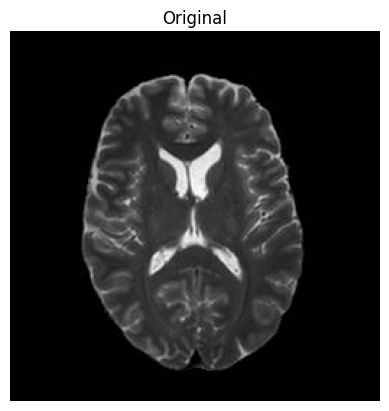

In [27]:
# Sample and display a random test (unseen) image and its augmentations

subject = test_ds.__getitem__(np.random.randint(0,batch_size))
img = subject[0]['image']
aug1 = subject[0]['aug'][0]
aug2 = subject[0]['aug'][1]
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')
plt.show()

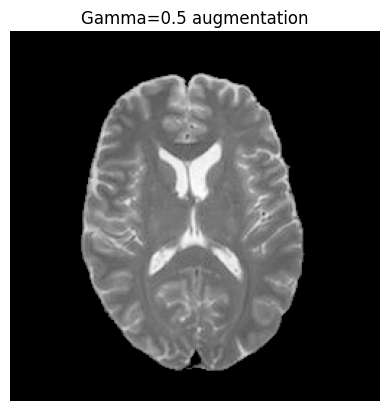

In [28]:
plt.imshow(aug1.squeeze().numpy(), cmap='gray')
plt.title('Gamma=0.5 augmentation')
plt.axis('off')
plt.show()

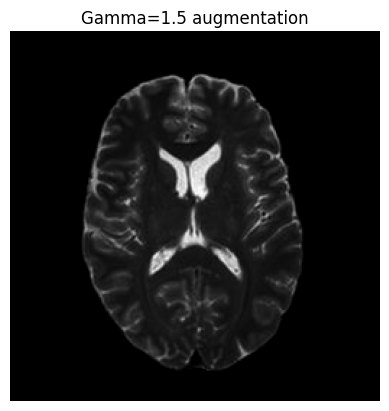

In [29]:
plt.imshow(aug2.squeeze().numpy(), cmap='gray')
plt.title('Gamma=1.5 augmentation')
plt.axis('off')
plt.show()

Anatomy shape: torch.Size([1, 1, 256, 256])


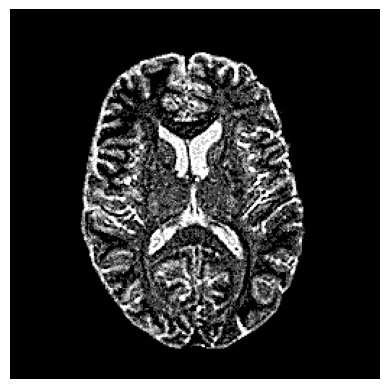

In [30]:
# Obtain and display the anatomy representation produced using constrastive learning from the image and augmentations

img = img.to(prism.device).unsqueeze(1)
mask = subject[prism.modality]['mask'].to(prism.device)

_, anatomy = prism.get_anatomy_representations(img, mask)

print(f"Anatomy shape: {anatomy.shape}")
plt.imshow(anatomy.detach().squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [44]:
# Obtain and display its latent style code

style_code, _, _ = prism.get_style_code(img)
print(f"Style code shape: {style_code.shape}")
print(f"Style code value: {style_code.detach().squeeze().cpu()}")

Style code shape: torch.Size([1, 2, 1, 1])
Style code value: tensor([-0.9101, -1.6664])


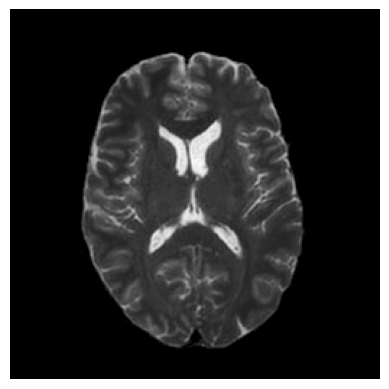

In [45]:
# Conditionally decode the anatomy and style to reconstruct the original image

rec_image = prism.decode(anatomy, style_code, mask)
plt.imshow(rec_image.detach().squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Warning: run this cell only if you wish to clear the kaggle output directory due to space constraints

# after downloading results/models, clear the kaggle output directory 
# !rm -rf /kaggle/working/*